# Big Data, PySpark, and MapReduce
By Stewart Charles Fisher II - ID: 25020928

Start Date: 22/11/2022

End Date: 13/12/2022

## Table of Contents

- [Import Libraries](#Import-Libraries)
- [Task 1 - Analysis of Nuclear Plants Dataset](#Task-1---Analysis-of-Nuclear-Plants-Dataset)
    - [Task 1.1 - Load the Data Into a PySpark DataFrame](#Task-1.1---Load-the-Data-Into-a-PySpark-DataFrame)
    - [Task 1.2 - Display Summary Statistics for the Data](#Task-1.2---Display-Summary-Statistics-for-the-Data)
        - [Normal Entry Metrics](#Calculate-the-minimum,-maximum,-mean,-and-median-for-the-'normal'-entries.)
        - [Abnormal Entry Metrics](#Calculate-the-minimum,-maximum,-mean,-and-median-for-the-'abnormal'-entries.)
        - [Normal Entry Boxplots](#Calculate-and-display-the-boxplots-for-the-'normal'-entries.)
        - [Abnormal Entry Boxplots](#Calculate-and-display-the-boxplots-for-the-'abnormal'-entries.)
    - [Task 1.3 - Display the Correlations in the Data](#Task-1.3---Display-the-Correlations-in-the-Data)
        - [Correlation Matrix](#Display-the-correlation-matrix.)
    - [Task 1.4 - Prepare the Data for Model Training](#Task-1.4---Prepare-the-Data-for-Model-Training)
    - [Task 1.5 - Train the Classification Prediction Models](#Task-1.5---Train-the-Classification-Prediction-Models)
        - [Decision Tree Model](#Train-a-decision-tree-using-the-training-set.)
        - [Support Vector Machine Model](#Train-a-support-vector-machine-using-the-training-set.)
        - [Artificial Neural Network](#Train-an-artificial-neural-network-using-the-training-set.)
- [Task 2 - MapReduce for Margie Travel Dataset](#Task-2---MapReduce-for-Margie-Travel-Dataset)
    - [Task 2.1 - Determine the Number of Flights From Each Airport](#Task-2.1---Determine-the-Number-of-Flights-From-Each-Airport)
        - [Number of Flights per Airport](#Output-the-number-of-flights-from-each-airport.)
        - [List of Unused Airports](#Get-a-list-of-the-airports-that-didn't-have-any-departures.)
    - [Task 2.2 - Display a List of Flight Information](#Task-2.2---Display-a-List-of-Flight-Information)
        - [List of Flight Information](#Create-a-list-of-all-the-relevant-flight-information.-Convert-the-departure-and-arrival-times-using-the-functions-that-were-created-to-do-so.)
    - [Task 2.3 - Calculate the Flight Distances](#Task-2.3---Calculate-the-Flight-Distances)
        - [Air Miles per Flight](#Output-the-amount-of-air-miles-per-flight-as-whole-miles,-in-descending-order.)
        - [Air Miles per Passenger](#Output-the-amount-of-air-miles-per-passenger-as-whole-miles,-in-descending-order.)

## Import Libraries

In [1]:
from datetime import datetime
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, isnan, when, count
from sklearn.metrics import confusion_matrix
import math
import matplotlib.pyplot as plot
import pandas as pd
import pyspark.pandas as ps
import numpy as np
import seaborn as sn

## Task 1 - Analysis of Nuclear Plants Dataset

### Task 1.1 - Load the Data Into a PySpark DataFrame

As a first step, you need to load the data from the file `nuclear_plants_small_dataset.csv’ into a Pyspark DataFrame. Before making any analysis, it is required to know if there are missing values in the data. Are there any missing values? Discuss how you will deal with missing values, even if there are no missing values in this data set.

#### Import PySpark and initialise a SparkSession.

In [2]:
import findspark
findspark.init()

from pyspark.sql.functions import *
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

#### Read in data from the Nuclear Plants dataset.

In [3]:
# Load data
nuclear = spark.read.csv("nuclear_plants_small_dataset.csv",header=True,inferSchema=True)

#### Check the inferred schema from pandas for the dataset.

In [4]:
# Print the schema
nuclear.printSchema()

root
 |-- Status: string (nullable = true)
 |-- Power_range_sensor_1: double (nullable = true)
 |-- Power_range_sensor_2: double (nullable = true)
 |-- Power_range_sensor_3 : double (nullable = true)
 |-- Power_range_sensor_4: double (nullable = true)
 |-- Pressure _sensor_1: double (nullable = true)
 |-- Pressure _sensor_2: double (nullable = true)
 |-- Pressure _sensor_3: double (nullable = true)
 |-- Pressure _sensor_4: double (nullable = true)
 |-- Vibration_sensor_1: double (nullable = true)
 |-- Vibration_sensor_2: double (nullable = true)
 |-- Vibration_sensor_3: double (nullable = true)
 |-- Vibration_sensor_4: double (nullable = true)



#### Edit column names to maintain ease of use.

##### In this case, I am targetting spaces that require standardisation.

In [5]:
nuclear1 = nuclear.withColumnRenamed('Power_range_sensor_3 ', 'Power_range_sensor_3').withColumnRenamed('Pressure _sensor_1', 'Pressure_sensor_1').withColumnRenamed('Pressure _sensor_2', 'Pressure_sensor_2').withColumnRenamed('Pressure _sensor_3', 'Pressure_sensor_3').withColumnRenamed('Pressure _sensor_4', 'Pressure_sensor_4')

#### Show twenty entries of the dataset to check it has formatted correctly, using the sample transform to return a fraction of the dataset, and storing the sample in an output DataFrame.

In [6]:
# Take a fraction of the dataset and output the sample
nuclear2 = nuclear1.sample(0.01)
nuclear2.show()

+--------+--------------------+--------------------+--------------------+--------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+
|  Status|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3|Power_range_sensor_4|Pressure_sensor_1|Pressure_sensor_2|Pressure_sensor_3|Pressure_sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+--------+--------------------+--------------------+--------------------+--------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+
|  Normal|              3.4671|              7.1667|             10.8298|              6.6486|           7.5676|           0.5098|           7.3705|           2.8472|           12.5734|            9.9609|           12.2318|            9.5547|
|Abnormal|               0.5

#### Check the number of records in the dataset and store the value in a python variable.

In [7]:
# Store the total number of entries in the dataset and output the value
totalNuclear = nuclear1.count()
totalNuclear

996

#### Check for any missing values.

In [8]:
## Count the number of missing values for each column
nuclear1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in nuclear1.columns]).show()

+------+--------------------+--------------------+--------------------+--------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+
|Status|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3|Power_range_sensor_4|Pressure_sensor_1|Pressure_sensor_2|Pressure_sensor_3|Pressure_sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+------+--------------------+--------------------+--------------------+--------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+
|     0|                   0|                   0|                   0|                   0|                0|                0|                0|                0|                 0|                 0|                 0|                 0|
+------+--------------------+-------

#### Remove records with NULL values, checking for any new changes.

In [9]:
nuclear3 = nuclear1.dropna()
nuclear3.count()

996

#### Create a dictionary for the status column. Replace any incorrect classes according to the new dictionary.

In [10]:
mapDict = {"normal": "Normal",
           "abnormal": "Abnormal"}
nuclear3 = nuclear3.replace(to_replace = mapDict,
                           subset = ["Status"])

### Task 1.2 - Display Summary Statistics for the Data

It is beneficial to understand the data by looking at the summary statistics. There are two groups of subjects (i.e., the normal group and the abnormal group) in this dataset. For each group, show the following summary statistics for each feature in a table: minimum, maximum, mean, and median values. For each group, plot the box plot for each feature.

#### Convert the dataset to a pandas DataFrame.

In [11]:
# Create a new pandas DataFrame that stores the contents of nuclear3
nuclear4 = nuclear3.toPandas()

#### Separate the dataset into 'normal' and 'abnormal' entries.

In [12]:
nuclearNormal = nuclear3.filter(col("Status") == "Normal")
nuclearNormalPan = nuclear4[nuclear4['Status'] == 'Normal']

In [13]:
nuclearAbnormal = nuclear3.filter(col("Status") == "Abnormal")
nuclearAbnormalPan = nuclear4[nuclear4['Status'] == 'Abnormal']

#### Calculate the minimum, maximum, mean, and median for the 'normal' entries.

##### Uncomment for a cleaner display of the table.

###### In the table, '50%' is the median.

In [14]:
nuclearNormalPan.describe().loc[['min','max','mean','50%']]
#nuclearNormal.summary("min", "max", "mean", "50%").show()

,Power_range_sensor_1,Power_range_sensor_2,Power_range_sensor_3,Power_range_sensor_4,Pressure_sensor_1,Pressure_sensor_2,Pressure_sensor_3,Pressure_sensor_4,Vibration_sensor_1,Vibration_sensor_2,Vibration_sensor_3,Vibration_sensor_4
min,0.085100,0.040300,4.382600,0.154700,0.024800,0.010400,0.077400,0.00580,0.009200,0.027700,0.064600,0.083100
max,12.129800,11.928400,14.098200,16.356800,56.856200,9.221200,12.647500,15.10850,31.498100,34.867600,53.238400,43.231400
mean,5.602453,6.844503,9.292054,8.701398,13.797526,3.415646,5.923353,5.58618,8.441437,9.699616,19.437804,10.925098
50%,5.178650,6.717650,9.262850,9.240850,10.634800,3.113000,5.739400,4.25915,7.449900,8.700750,16.464500,9.485450


#### Calculate the minimum, maximum, mean, and median for the 'abnormal' entries.

##### Uncomment for a cleaner display of the table.

###### In the table, '50%' is the median.

In [15]:
nuclearAbnormalPan.describe().loc[['min','max','mean','50%']]
#nuclearAbnormal.summary("min", "max", "mean", "50%").show()

,Power_range_sensor_1,Power_range_sensor_2,Power_range_sensor_3,Power_range_sensor_4,Pressure_sensor_1,Pressure_sensor_2,Pressure_sensor_3,Pressure_sensor_4,Vibration_sensor_1,Vibration_sensor_2,Vibration_sensor_3,Vibration_sensor_4
min,0.008200,0.389100,2.583966,0.062300,0.131478,0.008262,0.001224,0.029478,0.000000,0.018500,0.131784,0.009200
max,10.923078,10.154100,15.759900,17.235858,67.979400,10.242738,11.772400,16.555620,36.186438,34.331466,36.911454,26.466900
mean,4.396695,5.914043,9.164170,6.009146,14.600728,2.740270,5.575115,4.407824,7.887689,10.303570,10.938159,8.942085
50%,4.513550,5.932218,9.472050,5.399300,12.596150,2.382689,5.744257,3.322575,6.535950,8.973100,8.987269,8.137600


##### Calculate and display the boxplots for the 'normal' entries.

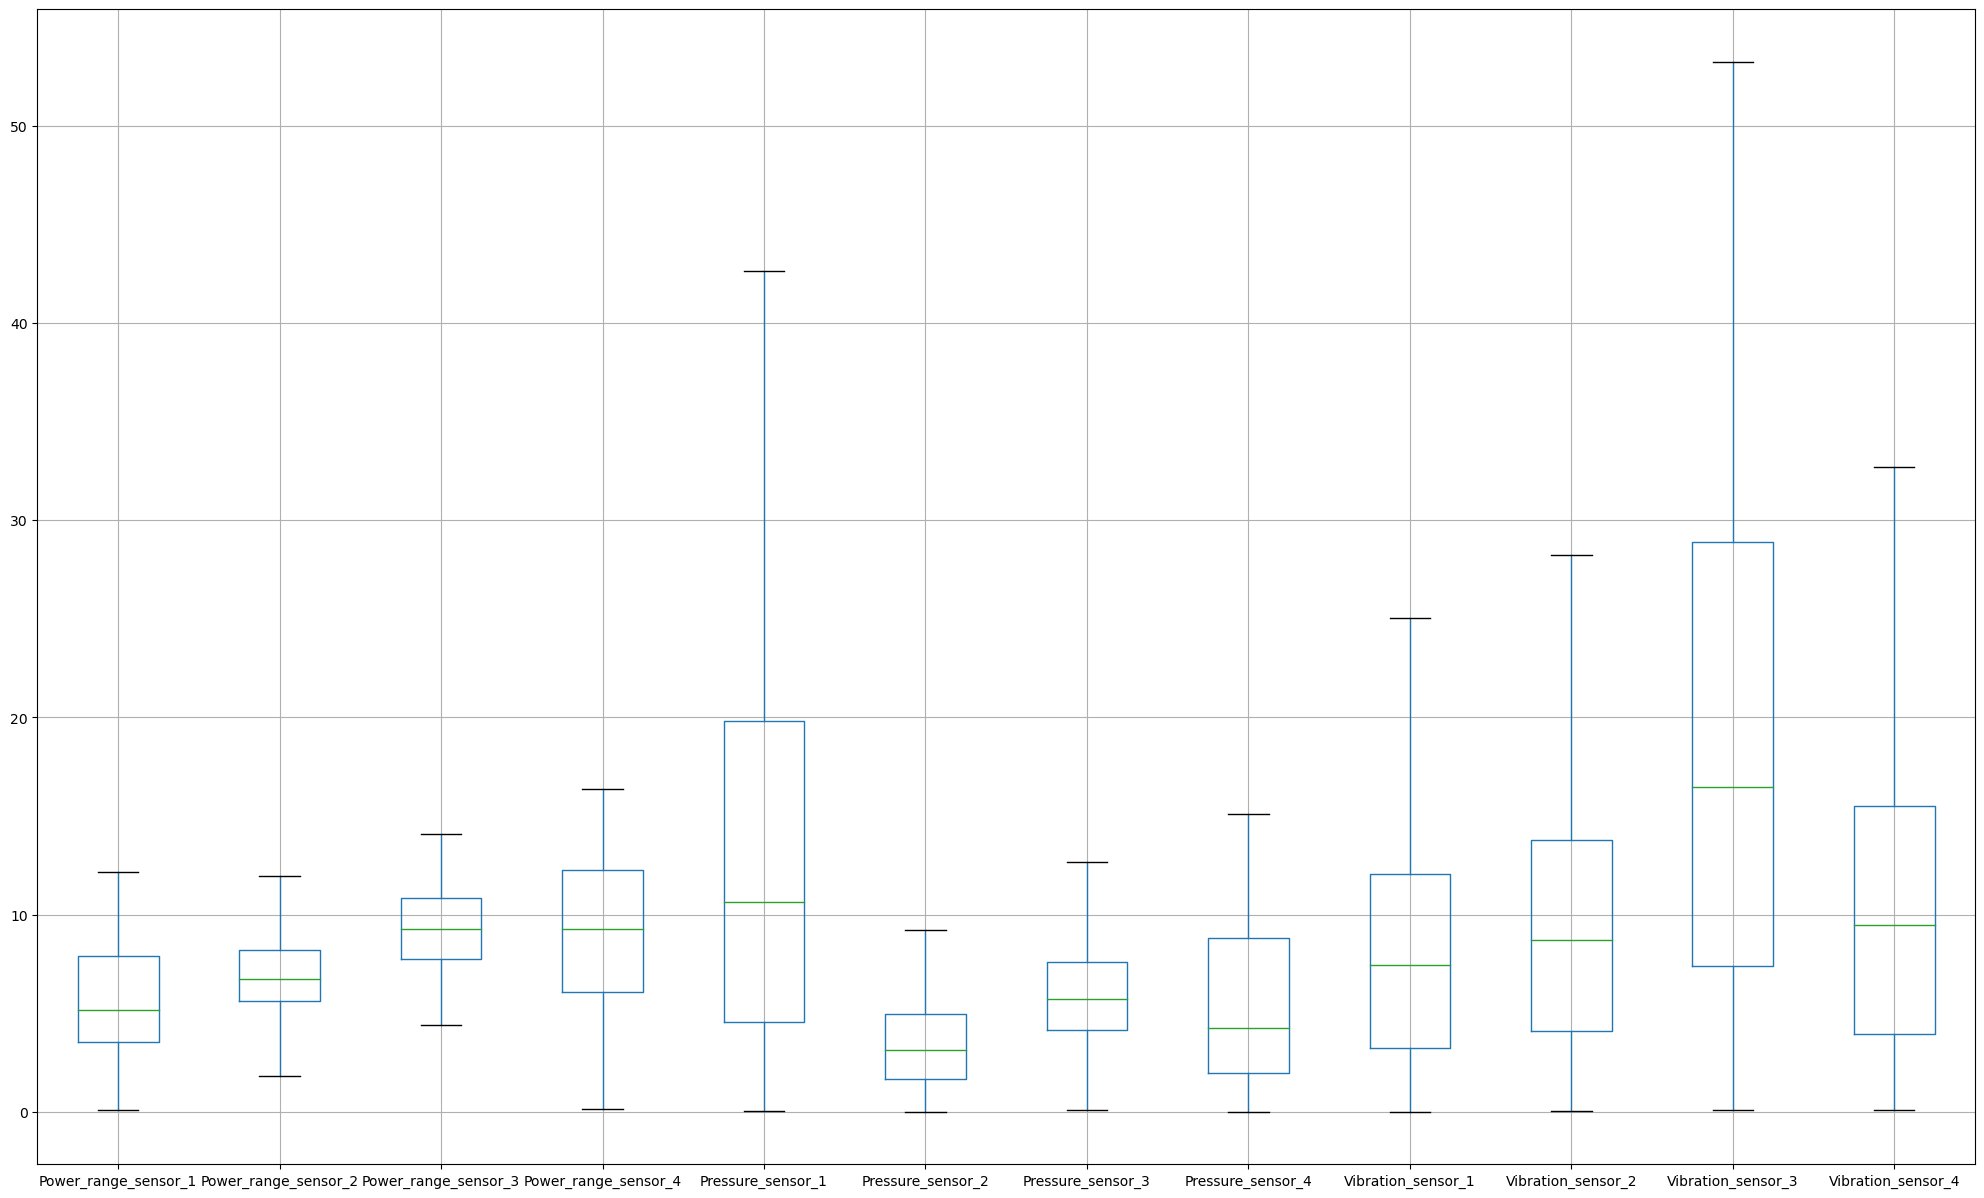

In [16]:
boxNormal = nuclearNormalPan.boxplot(figsize=(25,15), showfliers = False)

##### Calculate and display the boxplots for the 'abnormal' entries.

In [17]:
boxAbnormal = nuclearAbnormalPan.boxplot(figsize=(25,15), showfliers = False)

### Task 1.3 - Display the Correlations in the Data

To understand the relationship between features. If two features have high correlations, using only one of them could be enough for our analysis. Show in a table the correlation matrix of the features, where each element in the matrix shows the correlation coefficient of two features. Discuss your observations on the correlation matrix. Are there any features which are highly correlated? In any case, we will use all the features in the following tasks.

#### Display the correlation matrix.

##### Implementing the correlation matrix with pandas, displayed as a heatmap.


In [18]:
correlationPandas = nuclear4.corr()
sn.heatmap(correlationPandas, 
            xticklabels=correlationPandas.columns.values,
            yticklabels=correlationPandas.columns.values, annot=True)

C:\Users\chukl\AppData\Local\Temp\ipykernel_27192\1408763884.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlationPandas = nuclear4.corr()


<AxesSubplot:>

### Task 1.4 - Prepare the Data for Model Training

Shuffle the data samples and split it into a 70% training set and a 30% test set. How many examples in each group for the training dataset? How many examples in each group for the testing dataset? 

#### Generate a new DataFrame that contains a features column.

##### Collect a list of the column names.

In [19]:
nuclear3.columns

['Status',
 'Power_range_sensor_1',
 'Power_range_sensor_2',
 'Power_range_sensor_3',
 'Power_range_sensor_4',
 'Pressure_sensor_1',
 'Pressure_sensor_2',
 'Pressure_sensor_3',
 'Pressure_sensor_4',
 'Vibration_sensor_1',
 'Vibration_sensor_2',
 'Vibration_sensor_3',
 'Vibration_sensor_4']

##### Build a feature transformer using the list of column names.

In [20]:
assembler = VectorAssembler(inputCols=['Power_range_sensor_1',
                                       'Power_range_sensor_2',
                                       'Power_range_sensor_3',
                                       'Power_range_sensor_4',
                                       'Pressure_sensor_1',
                                       'Pressure_sensor_2',
                                       'Pressure_sensor_3',
                                       'Pressure_sensor_4',
                                       'Vibration_sensor_1',
                                       'Vibration_sensor_2',
                                       'Vibration_sensor_3',
                                        'Vibration_sensor_4'], outputCol= "features")

##### Create the features column. Show a sample to validate it has worked.

In [21]:
nuclear6 = assembler.transform(nuclear3)
nuclear6.sample(0.01).show(2)

+------+--------------------+--------------------+--------------------+--------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+--------------------+
|Status|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3|Power_range_sensor_4|Pressure_sensor_1|Pressure_sensor_2|Pressure_sensor_3|Pressure_sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|            features|
+------+--------------------+--------------------+--------------------+--------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+--------------------+
|Normal|              4.5767|              7.3654|              8.3011|              2.1002|          12.3978|            1.608|           4.0482|           2.0449|            9.8962|             6.656|           1

#### Create a new index column, using StringIndexer().

In [22]:
indexer = StringIndexer(inputCol="Status", outputCol="label")
nuclear7 = indexer.fit(nuclear6).transform(nuclear6)
nuclear7.sample(0.01).show()

+--------+--------------------+--------------------+--------------------+--------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+--------------------+-----+
|  Status|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3|Power_range_sensor_4|Pressure_sensor_1|Pressure_sensor_2|Pressure_sensor_3|Pressure_sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|            features|label|
+--------+--------------------+--------------------+--------------------+--------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+--------------------+-----+
|  Normal|              4.9384|              4.1675|              5.6369|              2.5845|           3.8532|           1.5918|           9.6893|           2.6529|           20.3648|     

#### Split the dataset into a training set and a test set, 7:3 respectively, using randomSplit().

##### A seed is being used to retain the same random split every single time this code is run. The number 34 produces the closest split, 70:30.

In [23]:
nuclearTrain, nuclearTest = nuclear7.randomSplit([0.70, 0.30], seed=34)

#### Count the number of entries in the training set.

In [24]:
nuclearTrain.count()

697

#### Count the number of entries in the test set.

In [25]:
nuclearTest.count()

299

#### Save the number of test entries to a variable.

In [26]:
nuclearTestCounter = nuclearTest.count()

### Task 1.5 - Train the Classification Prediction Models

Train a decision tree, a support vector machine model and an artificial neural network using the training set, and then apply the trained classifiers to the test set. You will obtain the predicted labels for the test set. Now evaluate and compare the classifiers, respectively, by computing the error rate (Incorrectly Classified Samples divided by Classified Sample). Calculate the sensitivity and specificity. Briefly discuss the error rate, sensitivity and specificity.

#### Create a function that can be used to output the error rate, sensitivity, and specificity.

The function will take in a confusion matrix, index the relevant values, and input them to the appropriate formulae.

In [27]:
def evaluateModel(matrix, count):
    errorRate = (matrix[0][1] + matrix[1][0]) / count
    
    sensitivity = (matrix[0][0] / (matrix[0][0] + matrix[1][0]))
    
    specificity = (matrix[1][1] / (matrix[0][1] + matrix[1][1]))   
    
    return errorRate, sensitivity, specificity

#### Train a decision tree using the training set.

In [28]:
nuclearTreeClassifier = DecisionTreeClassifier(labelCol= "label").fit(nuclearTrain)
nuclearTreePredictions = nuclearTreeClassifier.transform(nuclearTest)
nuclearTreePredictions.select("features", "label", "prediction").show(3)

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[0.03825,3.606516...|  0.0|       0.0|
|[0.250308,4.18822...|  0.0|       0.0|
|[0.41463,3.691482...|  0.0|       0.0|
+--------------------+-----+----------+
only showing top 3 rows



##### Calculate a confusion matrix.

In [29]:
nuclearTreePrime = nuclearTreePredictions.select("prediction").collect()
nuclearTreeOriginal = nuclearTreePredictions.select("label").collect()
treeConfusionMatrix = confusion_matrix(nuclearTreeOriginal, nuclearTreePrime)

##### Use the values from the confusion matrix to calculate error rate, sensitivity, and specificity.

In [30]:
treeErrorRate, treeSensitivity, treeSpecificity = evaluateModel(treeConfusionMatrix, nuclearTestCounter)
print("Error Rate: ", treeErrorRate)
print("Sensitivity: ", treeSensitivity)
print("Specificity: ", treeSpecificity)

Error Rate:  0.17725752508361203
Sensitivity:  0.8113207547169812
Specificity:  0.8357142857142857


#### Train a support vector machine using the training set.

In [31]:
nuclearSVM = LinearSVC(labelCol= "label", maxIter=50).fit(nuclearTrain)
nuclearSVMPredictions = nuclearSVM.transform(nuclearTest)
nuclearSVMPredictions.select("features", "label", "prediction").show(3)

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[0.03825,3.606516...|  0.0|       0.0|
|[0.250308,4.18822...|  0.0|       0.0|
|[0.41463,3.691482...|  0.0|       0.0|
+--------------------+-----+----------+
only showing top 3 rows



##### Calculate a confusion matrix.

In [32]:
nuclearSVMPrime = nuclearSVMPredictions.select("prediction").collect()
nuclearSVMOriginal = nuclearSVMPredictions.select("label").collect()
svmConfusionMatrix = confusion_matrix(nuclearSVMOriginal, nuclearSVMPrime)

##### Use the values from the confusion matrix to calculate error rate, sensitivity, and specificity.

In [33]:
svmErrorRate, svmSensitivity, svmSpecificity = evaluateModel(svmConfusionMatrix, nuclearTestCounter)
print("Error Rate: ", svmErrorRate)
print("Sensitivity: ", svmSensitivity)
print("Specificity: ", svmSpecificity)

Error Rate:  0.25418060200668896
Sensitivity:  0.740506329113924
Specificity:  0.75177304964539


#### Train an artificial neural network using the training set.

##### Establish the layers.

In [34]:
layers = [12, 12, 12, 2]

##### Use the model to calculate predictions.

In [35]:
nuclearNeuralModel = MultilayerPerceptronClassifier(featuresCol= 'features', labelCol= 'label', layers = layers, seed = 1).fit(nuclearTrain)
nuclearNeuralPredictions = nuclearNeuralModel.transform(nuclearTest)
nuclearNeuralPredictions.select("features", "label", "prediction").show(3)

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[0.03825,3.606516...|  0.0|       0.0|
|[0.250308,4.18822...|  0.0|       0.0|
|[0.41463,3.691482...|  0.0|       0.0|
+--------------------+-----+----------+
only showing top 3 rows



##### Calculate a confusion matrix.

In [36]:
nuclearNeuralPrime = nuclearNeuralPredictions.select("prediction").collect()
nuclearNeuralOriginal = nuclearNeuralPredictions.select("label").collect()
neuralConfusionMatrix = confusion_matrix(nuclearNeuralOriginal, nuclearNeuralPrime)

##### Use the values from the confusion matrix to calculate error rate, sensitivity, and specificity.

In [37]:
neuralErrorRate, neuralSensitivity, neuralSpecificity = evaluateModel(neuralConfusionMatrix, nuclearTestCounter)
print("Error Rate: ", neuralErrorRate)
print("Sensitivity: ", neuralSensitivity)
print("Specificity: ", neuralSpecificity)

Error Rate:  0.19063545150501673
Sensitivity:  0.7987421383647799
Specificity:  0.8214285714285714


## Task 2 - MapReduce for Margie Travel Dataset

### Task 2.1 - Determine the Number of Flights From Each Airport

Determine the number of flights from each airport; include a list of any airports not used.

#### Initialise a new SparkContext.

In [38]:
margie = spark.sparkContext

#### Read in data from the Margie Travel dataset.

In [39]:
passengerData = margie.textFile('AComp_Passenger_data_no_error.csv')

airportData = margie.textFile('Top30_airports_LatLong.csv')

#### Check the passenger data was read correctly. Filter out any null entries.

In [40]:
passengerData = passengerData.filter(lambda x: x != '')
passengerData.take(5)

['UES9151GS5,SQU6245R,DEN,FRA,1420564460,1049',
 'UES9151GS5,XXQ4064B,JFK,FRA,1420563917,802',
 'EZC9678QI6,SOH3431A,ORD,MIA,1420563649,250',
 'ONL0812DH1,SOH3431A,ORD,MIA,1420563649,250',
 'CYJ0225CH1,PME8178S,DEN,PEK,1420564409,1322']

#### Check the airport data was read correctly. Filter out any null entries.

In [41]:
airportData = airportData.filter(lambda x: x != '')
airportData.take(5)

['ATLANTA,ATL,33.636719,-84.428067',
 'BEIJING,PEK,40.080111,116.584556',
 'LONDON,LHR,51.4775,-0.461389',
 'CHICAGO,ORD,41.978603,-87.904842',
 'TOKYO,HND,35.552258,139.779694']

#### Split each string in the passenger data, so that they can be indexed.

In [42]:
passengerData1 = passengerData.map(lambda x: x.split(','))

#### Split each string in the airport data, so that they can be indexed.

In [43]:
airportData1 = airportData.map(lambda x: x.split(','))

#### Get a list of all of the flights. This will include the flight ID and the departing airport. Also, return the number of passengers as a value.

In [44]:
passengerData2 = passengerData1.map(lambda x: ((x[1], x[2]), 1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending = False)
for key, value in passengerData2.collect():
    print(f"Flight ID: {key[0]}, Airport: {key[1]}, Passengers: {value}")

Flight ID: ULZ8130D, Airport: CAN, Passengers: 27
Flight ID: GMO5938W, Airport: LHR, Passengers: 25
Flight ID: XXQ4064B, Airport: JFK, Passengers: 25
Flight ID: KJR6646J, Airport: IAH, Passengers: 23
Flight ID: SQU6245R, Airport: DEN, Passengers: 21
Flight ID: WSK1289Z, Airport: CLT, Passengers: 21
Flight ID: QHU1140O, Airport: CDG, Passengers: 21
Flight ID: FYL5866L, Airport: ATL, Passengers: 20
Flight ID: JVY9791G, Airport: PVG, Passengers: 20
Flight ID: SOH3431A, Airport: ORD, Passengers: 18
Flight ID: PME8178S, Airport: DEN, Passengers: 18
Flight ID: VYW5940P, Airport: LAS, Passengers: 17
Flight ID: YZO4444S, Airport: BKK, Passengers: 17
Flight ID: BER7172M, Airport: KUL, Passengers: 17
Flight ID: MBA8071P, Airport: KUL, Passengers: 16
Flight ID: XOY7948U, Airport: ATL, Passengers: 16
Flight ID: VYU9214I, Airport: ORD, Passengers: 15
Flight ID: VDC9164W, Airport: FCO, Passengers: 15
Flight ID: ATT7791R, Airport: AMS, Passengers: 15
Flight ID: TMV7633W, Airport: CGK, Passengers: 15


#### Output the number of flights from each airport.

In [45]:
passengerData3 = passengerData2.map(lambda x: (x[0][1], 1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending = False)
for key, value in passengerData3.collect():
    print(f"Airport: {key}, Flights: {value}")

Airport: DEN, Flights: 3
Airport: CAN, Flights: 2
Airport: IAH, Flights: 2
Airport: ATL, Flights: 2
Airport: ORD, Flights: 2
Airport: KUL, Flights: 2
Airport: CGK, Flights: 2
Airport: LHR, Flights: 1
Airport: CLT, Flights: 1
Airport: CDG, Flights: 1
Airport: LAS, Flights: 1
Airport: MUC, Flights: 1
Airport: HND, Flights: 1
Airport: PEK, Flights: 1
Airport: JFK, Flights: 1
Airport: PVG, Flights: 1
Airport: BKK, Flights: 1
Airport: FCO, Flights: 1
Airport: AMS, Flights: 1
Airport: MAD, Flights: 1
Airport: DFW, Flights: 1
Airport: MIA, Flights: 1


#### Create new RDDs of airport codes.

In [46]:
passengerData4 = passengerData1.map(lambda x: (x[2], 1)).reduceByKey(lambda x, y: x + y)
airportData2 = airportData1.map(lambda x: (x[1], 1)).reduceByKey(lambda x, y: x + y)

#### Get a list of the airports that didn't have any departures.

In [47]:
airportData3 = airportData2.union(passengerData4).reduceByKey(lambda x, y: x + y).filter(lambda x: x[1] <= 1)
for key, value in airportData3.collect():
    print(f"Airport: {key}")

Airport: LAX
Airport: HKG
Airport: SIN
Airport: SFO
Airport: PHX
Airport: FRA
Airport: DXB
Airport: IST


### Task 2.2 - Display a List of Flight Information

Create a list of flights based on the Flight id, this output should include number of passengers, relevant IATA/FAA codes, and departure and arrival times (times converted to HH:MM format).

#### Create functions that can take in the relevant time codes and output them in HH:MM format.

In [48]:
def timeConvert(unixTime):
    # Take in the time code and convert it to HH:MM format
    unixTime = int(unixTime)
    x = datetime.fromtimestamp(unixTime)
    y = x.strftime('%H:%M')
    return y

In [49]:
def timeConvertPlus(unixTime, unixTimePlus):
    # Convert the time codes from strings to floats
    unixTime = float(unixTime)
    unixTimePlus = float(unixTimePlus)
    unixTimePlus *= 60
    
    x = unixTime + unixTimePlus
    x = int(x)
    y = timeConvert(x)
    return y

#### Create a list of all the relevant flight information. Convert the departure and arrival times using the functions that were created to do so.

In [50]:
passengerData5 = passengerData1.map(lambda x: ((x[1], x[2], x[3], timeConvert(x[4]), timeConvertPlus(x[4], x[5])), 1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending = False)
for key, value in passengerData5.collect():
    print(f"Flight ID: {key[0]}, Departure Airport: {key[1]}, Arrival Airport: {key[2]}, Departure Time: {key[3]}, Arrival Time: {key[4]}, Passengers: {value}")

Flight ID: ULZ8130D, Departure Airport: CAN, Arrival Airport: DFW, Departure Time: 17:23, Arrival Time: 21:26, Passengers: 27
Flight ID: GMO5938W, Departure Airport: LHR, Arrival Airport: PEK, Departure Time: 17:11, Arrival Time: 10:48, Passengers: 25
Flight ID: XXQ4064B, Departure Airport: JFK, Arrival Airport: FRA, Departure Time: 17:05, Arrival Time: 06:27, Passengers: 25
Flight ID: KJR6646J, Departure Airport: IAH, Arrival Airport: BKK, Departure Time: 17:26, Arrival Time: 01:34, Passengers: 23
Flight ID: QHU1140O, Departure Airport: CDG, Arrival Airport: LAS, Departure Time: 17:14, Arrival Time: 12:07, Passengers: 21
Flight ID: SQU6245R, Departure Airport: DEN, Arrival Airport: FRA, Departure Time: 17:14, Arrival Time: 10:43, Passengers: 21
Flight ID: WSK1289Z, Departure Airport: CLT, Arrival Airport: DEN, Departure Time: 16:59, Arrival Time: 21:37, Passengers: 21
Flight ID: JVY9791G, Departure Airport: PVG, Arrival Airport: FCO, Departure Time: 17:16, Arrival Time: 13:05, Passeng

### Task 2.3 - Calculate the Flight Distances

Calculate the line-of-sight (nautical) miles for each flight and the total travelled by each passenger and thus output the passenger having earned the highest air miles.

#### Define a function to calculate the Haversine formula.

In [51]:
def haversine(lat1, long1, lat2, long2):
    # Convert the strings to floats
    lat1 = float(lat1)
    long1 = float(long1)
    lat2 = float(lat2)
    long2 = float(long2)
    
    # Convert decimal degrees to radians
    lat1, long1, lat2, long2 = map(math.radians, [lat1, long1, lat2, long2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = long2 - long1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2 # Half chord length squared
    c = 2 * math.asin(math.sqrt(a)) # Angular distance in radians
    r = 3440.069517056 # Mean radius of Earth in nautical miles
    return c * r


#### Create an RDD from airportData1 containing the airport and its coordinates.

In [52]:
airportData4 = airportData1.map(lambda x: [x[1], (x[2], x[3])])
#airportData4.collect()

#### Create an RDD from airportData4, where the key is the airport code.

In [53]:
airportData5 = airportData4.keyBy(lambda x: (x[0]))
#airportData5.collect()

#### Create an RDD from passengerData1, with the key as the departure airport code.

In [54]:
passengerData6 = passengerData1.keyBy(lambda x: (x[2]))
#passengerData6.collect()

#### Create an RDD by joining passengerData6 and airportData5 by their shared key.

In [55]:
passengerData7 = passengerData6.join(airportData5)
#passengerData7.collect()

#### Create an RDD from passengerData7, with the key as the arrival airport code.

In [56]:
passengerData8 = passengerData7.keyBy(lambda x: (x[1][0][3]))
#passengerData8.collect()

#### Create an RDD by joining passengerData8 and airportData5 by their shared key.

In [57]:
passengerData9 = passengerData8.join(airportData5)
#passengerData9.collect()

#### Locate the indices required for the upcoming step.

##### Example of passenger ID.

In [58]:
print(passengerData9.collect()[0][1][0][1][0][0])

POP2875LH3


##### Example of flight ID.

In [59]:
print(passengerData9.collect()[0][1][0][1][0][1])

VYW5940P


##### Example of Departure Coordinates. Individual coordinates are [0] and [1] respectively.

In [60]:
print(passengerData9.collect()[0][1][0][1][1][1])

('36.080056', '-115.15225')


##### Example of Arrival Coordinates. Individual coordinates are [0] and [1] respectively.

In [61]:
print(passengerData9.collect()[0][1][1][1])

('1.350189', '103.994433')


#### Create an RDD from passengerData9 by mapping the flight ID as the key, and the output of the Haversine formula as the value.

In [62]:
passengerData10 = passengerData9.map(lambda x: [x[1][0][1][0][1], haversine(x[1][0][1][1][1][0], x[1][0][1][1][1][1],
                                                x[1][1][1][0], x[1][1][1][1])]).reduceByKey(lambda x, y: x + y - y).sortBy(lambda x: x[1], ascending = False)

#### Output the amount of air miles per flight as whole miles, in descending order.

In [63]:
for key, value in passengerData10.collect():
    print(f"Flight: {key}, Air Miles: {value:.0f}")

Flight: YZO4444S, Air Miles: 8436
Flight: KJR6646J, Air Miles: 8025
Flight: BER7172M, Air Miles: 7694
Flight: VYW5940P, Air Miles: 7672
Flight: DAU2617A, Air Miles: 7538
Flight: FYL5866L, Air Miles: 7288
Flight: EWH6301Y, Air Miles: 7007
Flight: ULZ8130D, Air Miles: 7007
Flight: VYU9214I, Air Miles: 6285
Flight: WPW9201U, Air Miles: 6045
Flight: HUR0974O, Air Miles: 5821
Flight: PME8178S, Air Miles: 5503
Flight: XIL3623J, Air Miles: 5420
Flight: VDC9164W, Air Miles: 5312
Flight: JVY9791G, Air Miles: 4951
Flight: QHU1140O, Air Miles: 4718
Flight: GMO5938W, Air Miles: 4402
Flight: SQU6245R, Air Miles: 4367
Flight: HZT2506M, Air Miles: 4346
Flight: ATT7791R, Air Miles: 4170
Flight: XOY7948U, Air Miles: 3650
Flight: TMV7633W, Air Miles: 3535
Flight: XXQ4064B, Air Miles: 3341
Flight: MBA8071P, Air Miles: 2383
Flight: DKZ3042O, Air Miles: 2243
Flight: RPG3351U, Air Miles: 1558
Flight: WSK1289Z, Air Miles: 1160
Flight: SOH3431A, Air Miles: 1042
Flight: RUM0422W, Air Miles: 808
Flight: MOO1786

#### Create an RDD from passengerData9 by mapping the passenger ID as the key, and the output of the Haversine formula as the value.

In [64]:
passengerData11 = passengerData9.map(lambda x: [x[1][0][1][0][0], haversine(x[1][0][1][1][1][0], x[1][0][1][1][1][1],
                                                x[1][1][1][0], x[1][1][1][1])]).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending = False)

#### Output the amount of air miles per passenger as whole miles, in descending order.

In [65]:
for key, value in passengerData11.collect():
    print(f"Passenger: {key}, Air Miles: {value:.0f}")

Passenger: UES9151GS5, Air Miles: 131879
Passenger: BWI0520BG6, Air Miles: 124737
Passenger: DAZ3029XA0, Air Miles: 123083
Passenger: SPR4484HA6, Air Miles: 122258
Passenger: PUD8209OG3, Air Miles: 115813
Passenger: WBE6935NU3, Air Miles: 99159
Passenger: HCA3158QA6, Air Miles: 96994
Passenger: WYU2010YH8, Air Miles: 96736
Passenger: JJM4724RF7, Air Miles: 93043
Passenger: CKZ3132BR4, Air Miles: 92729
Passenger: EZC9678QI6, Air Miles: 89320
Passenger: LLZ3798PE3, Air Miles: 84096
Passenger: HGO4350KK1, Air Miles: 81796
Passenger: POP2875LH3, Air Miles: 81032
Passenger: CXN7304ER2, Air Miles: 78744
Passenger: YMH6360YP0, Air Miles: 76258
Passenger: VZY2993ME1, Air Miles: 73690
Passenger: EDV2089LK5, Air Miles: 70431
Passenger: JBE2302VO4, Air Miles: 69003
Passenger: SJD8775RZ4, Air Miles: 67451
Passenger: XFG5747ZT9, Air Miles: 66421
Passenger: CDC0302NN5, Air Miles: 63113
Passenger: MXU9187YC7, Air Miles: 61040
Passenger: WTC9125IE5, Air Miles: 59611
Passenger: KKP5277HZ7, Air Miles: 5